In [ ]:
!pip install flaml

     |████████████████████████████████| 157 kB 7.4 MB/s 
     |████████████████████████████████| 2.0 MB 55.0 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install scikit-learn==0.24

     |████████████████████████████████| 22.3 MB 59.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 29 kB/s 


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import flaml
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def laben(df,feat):
    """
    Функция проводит LabelEncodind и преобразует признак в категориальный
    """
    labenc = LabelEncoder()
    df[feat] = labenc.fit_transform(df[feat])
    df[feat] = df[feat].astype('category')
    return df[feat]

def datet(df, feat):
    """
    Функция преобазует признак в ттип datetime64[s]
    """
    df[feat] = df[feat].astype('datetime64[s]')
    return df[feat]

def ekran_chronom(df):
    """
    Функция преобразует таблицу chronom
    """
    feat = df.NPLV.unique()
    df_1 = pd.DataFrame(columns=['NPLV','TYPE_OPER','VR', 'O2'])
    for i in feat:
        df_2 = df[df['NPLV']==i].sort_values(by='VR_NACH')
        lst = []
        for j in df_2.index:
            lst.append(str(df_2.TYPE_OPER.loc[j]))
        df_1.loc[len(df_1)] = [i,','.join(sorted(set(lst))), int(pd.Timedelta(df_2.VR_KON.iloc[-1] - df_2.VR_NACH.iloc[0]).seconds), int(df_2.O2.sum())]
    return df_1

def ekran_lom(df):
    """
    Функция преобразует таблицу lom
    """
    feat = df.NPLV.unique()
    df_1 = pd.DataFrame(columns=['NPLV','VDL','VES'])
    for i in feat:
        df_2 = df[df['NPLV']==i]
        lst = []
        ves_sum = 0
        for j in df_2.index:
            lst.append(str(df_2.VDL.loc[j]))
            ves_sum += df.VES.loc[j]
        df_1.loc[len(df_1)] = [i, ','.join(sorted(set(lst))), int(ves_sum)]
    return df_1

def ekran_plavki(df):
    """
    Функция преобразует таблицу plavki
    """
    feat = df.NPLV.unique()
    num = [i for i in feat if df.NPLV.to_list().count(i)>1]
    return num

def ekran_produv(df):
    """
    Функция преобразует таблицу produv
    """
    feat = df.NPLV.unique()
    df_1 = pd.DataFrame(columns=['NPLV','RAS','POL'])
    for i in feat:
        df_2 = df[df['NPLV']==i]
        ras_list = []
        pol_list = []
        for j in df_2.index:
            ras_list.append(df_2.RAS.loc[j])
            pol_list.append(df_2.POL.loc[j])
        df_1.loc[len(df_1)] = [i, float(max(ras_list)), float(np.mean(pol_list))]
    return df_1

def ekran_sip(df):
    """
    Функция преобразует таблицу sip
    """
    feat = df.NPLV.unique()
    df_1 = pd.DataFrame(columns=['NPLV','VDSYP','VSSYP', 'DAT_OTD'])
    for i in feat:
        df_2 = df[df['NPLV']==i].sort_values(by='DAT_OTD')
        lst = []
        ves_sum = 0
        for j in df_2.index:
            lst.append(str(df_2.VDSYP.loc[j]))
            ves_sum += df_2.VSSYP.loc[j]
        df_1.loc[len(df_1)] = [i, ','.join(sorted(set(lst))), int(ves_sum), int(pd.Timedelta(df_2.DAT_OTD.iloc[-1] - df_2.DAT_OTD.iloc[0]).seconds)]
    return df_1

def concat(train_data, test_data):
    '''Функция соединяет несколько датасетов в один'''
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def separate(all_data):
    """
    Функция разделяет датасет на train и valid
    """
    return all_data.loc[:2058], all_data.loc[2059:]

def OneHotEncoding(df): # не используем
    """
    Функция производит OneHotEncoding
    """
    dd = df.select_dtypes(include='category').columns
    if len(dd)>1:
        for i in dd:
            df = pd.concat([df, pd.get_dummies(df[i], prefix=(i+'M'))], axis=1)
            df.drop(i, axis=1, inplace=True)
        return df
    if len(dd)==1:
        df = pd.concat([df, pd.get_dummies(df[dd], prefix=(dd+'M'))], axis=1)
        df.drop(dd, axis=1, inplace=True)
        return df
    else:
        print(False)

def metric(answers, user_csv):
    """
    Функция метрики
    """
    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)
    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)
    N = np.size(answers['C'])
    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [ ]:
chronom_test = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/chronom_test.csv')
chronom_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/chronom_train.csv')
# NPLV	номер плавки
# TYPE_OPER	тип операции
# NOP	наименование операции
# VR_NACH	время начала операции
# VR_KON	время окончания операции
# O2	количество кислорода, израсходованное на операцию

In [ ]:
chronom_all = concat(chronom_train, chronom_test)
chronom_all.drop('Unnamed: 0', axis = 1 , inplace=True)
list_feat = ['VR_NACH','VR_KON']
for i in list_feat:
    chronom_all[i] = datet(chronom_all, i)
chronom_all = chronom_all.dropna(subset=['VR_KON'])
chronom_all = chronom_all.drop(chronom_all[chronom_all['VR_NACH'] < '2021'].index)
chronom_all = ekran_chronom(chronom_all)
chronom_all.drop(chronom_all[chronom_all.NPLV == 512233].index, inplace=True)
chronom_all.drop(chronom_all[chronom_all.NPLV == 511135].index, inplace=True)
chronom_all.drop(chronom_all[chronom_all.NPLV == 511156].index, inplace=True)
chronom_all.drop(chronom_all[chronom_all.NPLV == 512299].index, inplace=True)
chronom_all.NPLV = chronom_all.NPLV.astype('int64')
chronom_all.O2 = chronom_all.O2.astype('int64')
chronom_all.reset_index(drop=True, inplace=True)
chronom_train_new, chronom_test_new = separate(chronom_all)

In [ ]:
chugun_test = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/chugun_test.csv')
chugun_test.drop('DATA_ZAMERA', 1, inplace=True)
chugun_test.reset_index(drop=True, inplace=True)
chugun_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/chugun_train.csv')
chugun_train.drop('DATA_ZAMERA', 1, inplace=True)
# NPLV	номер плавки
# VES	вес чугуна
# T	температура чугуна
# SI	SI вчугуне
# MN	MN в чугуне
# S	S в чугуне
# P	P в чугуне
# CR	CR в чугуне
# NI	NI в чугуне
# CU	CU в чугуне

In [ ]:
chugun_train.drop(chugun_train[chugun_train.NPLV == 512233].index,inplace=True)
chugun_train.drop(chugun_train[chugun_train.NPLV == 511135].index, inplace=True)
chugun_train.drop(chugun_train[chugun_train.NPLV == 511156].index, inplace=True)
chugun_train.drop(chugun_train[chugun_train.NPLV == 512299].index, inplace=True)
chugun_train.reset_index(drop=True, inplace=True)

In [ ]:
gas_test = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/gas_test.csv')
gas_test_new = gas_test.groupby('NPLV').agg({'O2_pressure':'mean', 'T фурмы 2':'mean', 'T фурмы 1':'mean','AR':'mean', 'CO': 'mean', 'CO2':'median', 'H2':'median', 'N2':'mean', 'O2':'median', 'T':'mean', 'V':'mean'}).reset_index()
gas_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/gas_train.csv')
gas_train_new = gas_train.groupby('NPLV').agg({'O2_pressure':'mean', 'T фурмы 2':'mean', 'T фурмы 1':'mean','AR':'mean', 'CO': 'mean', 'CO2':'median', 'H2':'median', 'N2':'mean', 'O2':'median', 'T':'mean', 'V':'mean'}).reset_index()
# O2_pressure	Давление кислорода
# T фурмы 2	Температура 2-ой фурмы
# T фурмы 1	Температура 1-ой фурмы
# AR	доля AR в отх. газах 
# CO	доля CO в отх. газах 
# CO2	доля CO2 в отх. газах 
# H2	доля H2 в отх. газах 
# N2	доля N2 в отх. газах 
# O2	доля O2 в отх. газах 
# T	температура отходящих газов
# V	объем выходящих газов
# NPLV	номер плавки
# Time	дата и время замера хим. состава отходящих газов

In [ ]:
gas_train_new.drop(gas_train_new[gas_train_new.NPLV == 512233].index,inplace=True)
gas_train_new.drop(gas_train_new[gas_train_new.NPLV == 511135].index, inplace=True)
gas_train_new.drop(gas_train_new[gas_train_new.NPLV == 511156].index, inplace=True)
gas_train_new.drop(gas_train_new[gas_train_new.NPLV == 512299].index, inplace=True)
gas_train_new.reset_index(drop=True, inplace=True)

In [ ]:
lom_test = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/lom_test.csv')
lom_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/lom_train.csv')
# NPLV	номер плавки
# VDL	код лома
# NML	наименование лома
# VES	вес лома

In [ ]:
lom_all = concat(lom_train,lom_test)
lom_all.drop('NML',1,inplace=True)
lom_all = ekran_lom(lom_all)
lom_all.drop(lom_all[lom_all.NPLV == 512233].index,inplace=True)
lom_all.drop(lom_all[lom_all.NPLV == 511135].index, inplace=True)
lom_all.drop(lom_all[lom_all.NPLV == 511156].index, inplace=True)
lom_all.drop(lom_all[lom_all.NPLV == 512299].index, inplace=True)
lom_all.NPLV = lom_all.NPLV.astype('int64')
lom_all.VES = lom_all.VES.astype('int64')
lom_all.reset_index(drop=True, inplace=True)
lom_train_new, lom_test_new = separate(lom_all)

In [ ]:
plavki_test = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/plavki_test.csv')
plavki_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/plavki_train.csv')
# plavka_VR_NACH	время начала плавки
# plavka_VR_KON	время окончания плавки
# plavka_NMZ	марка заданная 
# plavka_NAPR_ZAD	направление разливки
# plavka_STFUT	стойкость футеровки конвертера
# plavka_TIPE_FUR	тип фурмы
# plavka_ST_FURM	стойкость фурмы
# plavka_TIPE_GOL	тип головки фурмы
# plavka_ST_GOL	стойкость головки фурмы

In [ ]:
plavki_all = concat(plavki_train, plavki_test)
list_feat = ['plavka_NMZ','plavka_TIPE_FUR', 'plavka_TIPE_GOL', 'plavka_NAPR_ZAD']
for i in list_feat:
    plavki_all[i] = laben(plavki_all, i)
plavki_all.drop(['plavka_NMZ','plavka_VR_NACH', 'plavka_VR_KON', 'plavka_STFUT'], 1, inplace=True)
plavki_all.drop(plavki_all[plavki_all.NPLV == 512233].index,inplace=True)
plavki_all.drop(plavki_all[plavki_all.NPLV == 511135].index, inplace=True)
plavki_all.drop(plavki_all[plavki_all.NPLV == 511156].index, inplace=True)
plavki_all.drop(plavki_all[plavki_all.NPLV == 512299].index, inplace=True)
plavki_all.reset_index(drop=True, inplace=True)
plavki_train_new, plavki_test_new = separate(plavki_all)

In [ ]:
produv_test = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/produv_test.csv')
produv_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/produv_train.csv')
# NPLV	номер плавки
# SEC	время измерения
# RAS	расход кислорода на продувку
# POL	положение фурмы для продувки

In [ ]:
produv_all = concat(produv_train, produv_test)
produv_all.drop('SEC',1,inplace=True)
produv_all = ekran_produv(produv_all)
produv_all.drop(produv_all[produv_all.NPLV == 512233].index,inplace=True)
produv_all.drop(produv_all[produv_all.NPLV == 511135].index, inplace=True)
produv_all.drop(produv_all[produv_all.NPLV == 511156].index, inplace=True)
produv_all.drop(produv_all[produv_all.NPLV == 512299].index, inplace=True)
produv_all.reset_index(drop=True, inplace=True)
produv_train_new, produv_test_new = separate(produv_all)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/sample_submission.csv')

In [ ]:
sip_test = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/sip_test.csv')
sip_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/sip_train.csv')
# NPLV	номер плавки
# VDSYP	вид сыпучих
# NMSYP	наименование сыпучих
# VSSYP	вес сыпучих
# DAT_OTD	дата и время отдачи

In [ ]:
sip_all = concat(sip_train,sip_test)
sip_all.drop('NMSYP',1, inplace=True)
sip_all.DAT_OTD = datet(sip_all, 'DAT_OTD')
sip_all = ekran_sip(sip_all)
sip_all.VDSYP = laben(sip_all, 'VDSYP')
sip_all.drop(sip_all[sip_all.NPLV == 512233].index,inplace=True)
sip_all.drop(sip_all[sip_all.NPLV == 511135].index, inplace=True)
sip_all.drop(sip_all[sip_all.NPLV == 511156].index, inplace=True)
sip_all.drop(sip_all[sip_all.NPLV == 512299].index, inplace=True)
sip_all.reset_index(drop=True, inplace=True)
sip_all.VSSYP = sip_all.VSSYP.astype('int64')
sip_train_new, sip_test_new = separate(sip_all)

In [ ]:
target_train = pd.read_csv('/content/drive/MyDrive/Evraz/task1/task1/data_task1/data_task1/target_train.csv')
target_train = target_train.dropna()
target_train.drop(target_train[target_train.NPLV == 511135].index, inplace=True)
target_train.reset_index(drop=True, inplace=True)
# C	содержание углерода в металле
# TST	температура металла
# NPLV	номер плавки

In [ ]:
all_tables_train = chronom_train_new.merge(chugun_train, on='NPLV')
all_tables_train = all_tables_train.merge(gas_train_new, on='NPLV')
all_tables_train = all_tables_train.merge(lom_train_new, on='NPLV')
all_tables_train = all_tables_train.merge(plavki_train_new, on='NPLV')
all_tables_train = all_tables_train.merge(produv_train_new, on='NPLV')
all_tables_train = all_tables_train.merge(sip_train_new, on='NPLV')
all_tables_train = all_tables_train.merge(target_train, on='NPLV')
all_tables_train.drop('NPLV',1,inplace=True)

In [ ]:
all_tables_test = chronom_test_new.merge(chugun_test, on='NPLV')
all_tables_test = all_tables_test.merge(gas_test_new, on='NPLV')
all_tables_test = all_tables_test.merge(lom_test_new, on='NPLV')
all_tables_test = all_tables_test.merge(plavki_test_new, on='NPLV')
all_tables_test = all_tables_test.merge(produv_test_new, on='NPLV')
all_tables_test = all_tables_test.merge(sip_test_new, on='NPLV')
all_tables_test.drop('NPLV',1,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


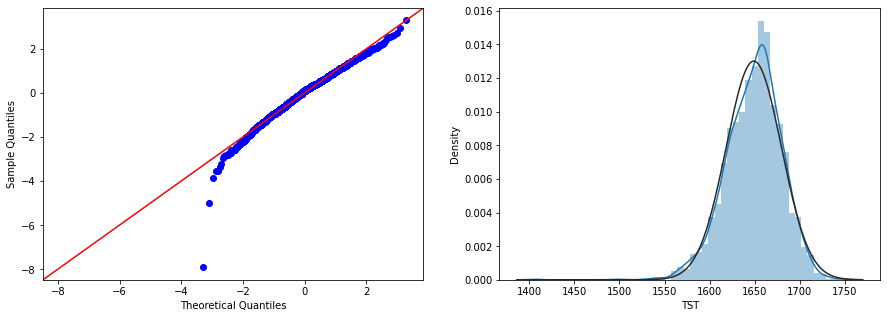

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
sm.qqplot(all_tables_train.TST, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(all_tables_train.TST, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


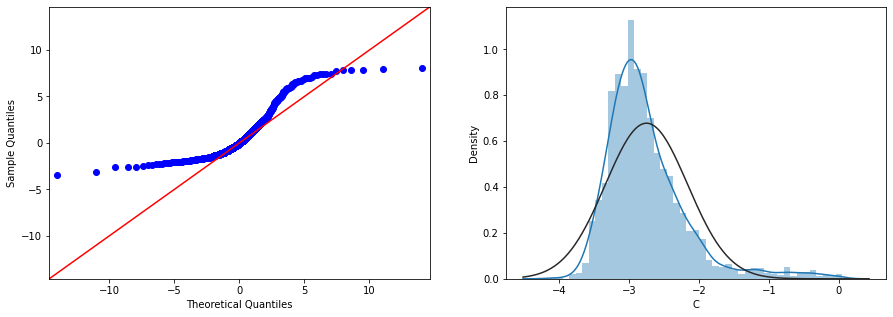

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
sm.qqplot(np.log(all_tables_train.C), stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(np.log(all_tables_train.C), kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [ ]:
all_tables_train_number = all_tables_train.select_dtypes(exclude=[object])
all_tables_train_str = all_tables_train.select_dtypes(include=[object])
all_tables_test_number = all_tables_test.select_dtypes(exclude=[object])
all_tables_tets_str = all_tables_test.select_dtypes(include=[object])

In [ ]:
X_tr = all_tables_train_number.drop(['C','TST'],1)
y_1 = all_tables_train_number['TST']
y_2 = np.log(all_tables_train_number['C'])
standart = StandardScaler()
X_tr = standart.fit_transform(X_tr)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_tr, y_1, test_size=0.33, random_state=42)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_tr, y_2, test_size=0.33, random_state=42)

In [ ]:
X_ts = all_tables_test_number
X_ts = standart.transform(X_ts)

In [ ]:
automl_1 = AutoML()
settings_1 = {
    "time_budget": 180,
    "metric": 'r2',
    "estimator_list": ['lgbm', 'xgboost', 'catboost'],
    "task": 'regression'}                           
automl_1.fit(X_train=X_train_1, y_train=y_train_1, X_val=X_valid_1, y_val=y_valid_1, **settings_1)  

print('Лучшие гиперпараметры для TST:', automl_1.best_config)
print(f'Лучшая метрика для TST: {automl_1.best_loss}')
print(f'Время на обучение для TST: {automl_1.best_config_train_time} s')

automl_1.model
y_pred_1 = automl_1.predict(X_valid_1)
print('score для TST', '=', (mean_absolute_error(y_valid_1, y_pred_1))) 

[flaml.automl: 10-31 07:50:28] {1463} INFO - Data split method: uniform
[flaml.automl: 10-31 07:50:28] {1467} INFO - Evaluation method: holdout
[flaml.automl: 10-31 07:50:28] {1515} INFO - Minimizing error metric: 1-r2
[flaml.automl: 10-31 07:50:28] {1552} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl: 10-31 07:50:28] {1793} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-31 07:50:28] {1911} INFO - Estimated sufficient time budget=3877s. Estimated necessary time budget=7s.
[flaml.automl: 10-31 07:50:28] {1987} INFO -  at 0.4s,	estimator lgbm's best error=0.8109,	best estimator lgbm's best error=0.8109
[flaml.automl: 10-31 07:50:28] {1793} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-31 07:50:28] {1987} INFO -  at 0.4s,	estimator lgbm's best error=0.8109,	best estimator lgbm's best error=0.8109
[flaml.automl: 10-31 07:50:28] {1793} INFO - iteration 2, current learner lgbm
[flaml.automl: 10-31 07:50:28] {1987} INFO -  at 

Лучшие гиперпараметры для TST: {'early_stopping_rounds': 33, 'learning_rate': 0.02502472461274365, 'n_estimators': 5669}
Лучшая метрика для TST: 0.5272374091968312
Время на обучение для TST: 2.821840524673462 s
score для TST = 16.601835144382722


In [ ]:
automl_2 = AutoML()
settings_2 = {
    "time_budget": 180,
    "metric": 'r2',
    "estimator_list": ['lgbm', 'xgboost', 'catboost'],
    "task": 'regression'}                           
automl_2.fit(X_train=X_train_2, y_train=y_train_2, X_val=X_valid_2, y_val=y_valid_2, **settings_2)

print('Лучшие гиперпараметры для C:', automl_2.best_config)
print(f'Лучшая метрика для C: {automl_1.best_loss}')
print(f'Время на обучение для C: {automl_2.best_config_train_time} s')

automl_2.model
y_pred_2 = automl_2.predict(X_valid_2)
print('score для C', '=', (mean_absolute_error(np.exp(y_valid_2), np.exp(y_pred_2)))) 

[flaml.automl: 10-31 07:53:28] {1463} INFO - Data split method: uniform
[flaml.automl: 10-31 07:53:28] {1467} INFO - Evaluation method: holdout
[flaml.automl: 10-31 07:53:28] {1515} INFO - Minimizing error metric: 1-r2
[flaml.automl: 10-31 07:53:28] {1552} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl: 10-31 07:53:28] {1793} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-31 07:53:28] {1911} INFO - Estimated sufficient time budget=274s. Estimated necessary time budget=0s.
[flaml.automl: 10-31 07:53:28] {1987} INFO -  at 0.0s,	estimator lgbm's best error=0.8417,	best estimator lgbm's best error=0.8417
[flaml.automl: 10-31 07:53:28] {1793} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-31 07:53:28] {1987} INFO -  at 0.1s,	estimator lgbm's best error=0.8417,	best estimator lgbm's best error=0.8417
[flaml.automl: 10-31 07:53:28] {1793} INFO - iteration 2, current learner lgbm
[flaml.automl: 10-31 07:53:28] {1987} INFO -  at 0

Лучшие гиперпараметры для C: {'early_stopping_rounds': 16, 'learning_rate': 0.05860143758327679, 'n_estimators': 7283}
Лучшая метрика для C: 0.5272374091968312
Время на обучение для C: 1.2459328174591064 s
score для C = 0.025178565318712116


In [ ]:
answer_df_train = pd.DataFrame({'TST':y_valid_1, 'C':y_valid_2})
pred_df_train = pd.DataFrame({'TST':automl_1.predict(X_valid_1), 'C':np.exp(automl_2.predict(X_valid_2))})
metr = metric(answer_df_train, pred_df_train)
metr

0.3397058823529412

In [ ]:
X_tr_TST = all_tables_train_number.drop('C',1)
X_tr_C = all_tables_train_number.drop('TST',1)
y_c = np.log(all_tables_train_number['C'])
y_tst = all_tables_train_number['TST']
standart = StandardScaler()
X_tr_TST = standart.fit_transform(X_tr_TST)
X_tr_C = standart.fit_transform(X_tr_C)
X_train_tst, X_valid_tst, y_train_tst, y_valid_tst = train_test_split(X_tr_TST, y_tst, test_size=0.33, random_state=42)
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X_tr_C, y_c, test_size=0.33, random_state=42)

In [ ]:
automl_tst = AutoML()
settings_tst = {
    "time_budget": 180,
    "metric": 'r2',
    "estimator_list": ['lgbm', 'xgboost', 'catboost'],
    "task": 'regression'}                           
automl_tst.fit(X_train=X_train_tst, y_train=y_train_tst, X_val=X_valid_tst, y_val=y_valid_tst, **settings_tst)  

print('Лучшие гиперпараметры для tst_new:', automl_tst.best_config)
print(f'Лучшая метрика для tst_new: {automl_tst.best_loss}')
print(f'Время на обучение для tst_new: {automl_tst.best_config_train_time} s')

automl_tst.model
y_pred_tst = automl_tst.predict(X_valid_tst)
print('score для tst_new', '=', (mean_absolute_error(y_valid_tst, y_pred_tst))) 

In [ ]:
automl_c = AutoML()
settings_c = {
    "time_budget": 180,
    "metric": 'r2',
    "estimator_list": ['lgbm', 'xgboost', 'catboost'],
    "task": 'regression'}                           
automl_c.fit(X_train=X_train_c, y_train=y_train_c, X_val=X_valid_c, y_val=y_valid_c, **settings_c)  

print('Лучшие гиперпараметры для C_new:', automl_c.best_config)
print(f'Лучшая метрика для C_new: {automl_c.best_loss}')
print(f'Время на обучение для C_new: {automl_c.best_config_train_time} s')

automl_c.model
y_pred_c = automl_c.predict(X_valid_c)
print('score для C_new', '=', (mean_absolute_error(np.exp(y_valid_c), np.exp(y_pred_c)))) 

In [ ]:
c = automl_2.predict(X_ts)

In [ ]:
all_tables_test_number_1 = all_tables_test_number
all_tables_test_number_1['C'] = np.exp(c)
# all_tables_test_number_1 = all_tables_test_number_1.drop('TST',1,inplace=True)
X_ts_1 = all_tables_test_number_1
X_ts_1 = standart.fit_transform(X_ts_1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tst = automl_tst.predict(X_ts_1)

In [ ]:
pred_df_test = pd.DataFrame({'NPLV': sample_submission.NPLV,'TST':automl_1.predict(X_ts), 'C':np.exp(automl_2.predict(X_ts))})

In [ ]:
pred_df_test_1 =  pd.DataFrame({'NPLV': sample_submission.NPLV,'TST':tst, 'C':np.exp(c)})

,NPLV,TST,C
0,512324,1621.093353,0.024012
1,512327,1618.074985,0.016594
2,512328,1680.393290,0.175834
3,512331,1618.071704,0.016594
4,512333,1655.970486,0.113656
...,...,...,...
775,513369,1618.166600,0.016531
776,513370,1618.160128,0.016595
777,513371,1618.143030,0.016594
778,513372,1618.103558,0.016599


In [ ]:
prediction = pred_df_test.to_csv('evraz_14.csv', index=False)
predictions = pd.read_csv('/content/evraz_14.csv')
predictions

,NPLV,TST,C
0,512324,1652.251220,0.037221
1,512327,1648.007902,0.046454
2,512328,1650.214619,0.060392
3,512331,1641.590586,0.096554
4,512333,1656.695045,0.082941
...,...,...,...
775,513369,1640.332304,0.109469
776,513370,1651.106519,0.125532
777,513371,1655.041736,0.090544
778,513372,1658.879778,0.072067
